## **TECH CHALLENGE - Fase 02**

#### **O problema**

Imagine que você foi escalado para um time de investimentos e precisará
realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para
criar uma série temporal e prever diariamente o fechamento da base.
Para isso, utilize a base de dados contida no site da Investing
https://br.investing.com/indices/bovespa-historical-data) e selecione o período
“diário”, com o intervalo de tempo que achar adequado.
Você precisará demonstrar para o time de investimentos:
1. O modelo com o storytelling, desde a captura do dado até a entrega do
modelo;
2. Justificar a técnica utilizada;
3. Atingir uma acuracidade adequada (acima de 70%). 

##### 1. **Contexto do problema**
O mercado financeiro é extremamente dinâmico e as variações nos preços de ativos influenciam diretamente as tomadas de decisão. Neste projeto, nosso objetivo é construir um modelo preditivo eficiente e robusto, capaz de fornecer previsões de curto prazo para os preços de fechamento do Ibovespa.

A escolha do modelo apropriado e a avaliação de sua performance são etapas cruciais, já que modelos mal ajustados podem levar a previsões inconsistentes e a riscos desnecessários. Assim, este projeto adota uma abordagem comparativa entre SARIMAX, Prophet e XGBoost, escolhendo o modelo mais adequado para a necessidade específica da equipe de investimentos. Esses foram os modelos mais robustos vistos em aula e considerados entãos os mais adequados a importância deste projeto tendo em vista que se trata de um problema de ordem financeira observei que estes eram mais apropriados para esse objetivo. 



##### 2. **Realizando os imports das bibliotecas necessárias**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
import pmdarima as pm
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf
from statsforecast import StatsForecast


/home/naina/miniconda3/envs/PythonEnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* ##### Observação: apenas silenciando alguns warnings para manter o código mais limpo

In [2]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore")

##### 3. **Coleta e exploração dos dados**

Utilizamos dados históricos do Ibovespa no intervalo temporal que vai de 11.10.2010 a 09.10.2024, um dos índices mais importantes do mercado brasileiro. A série temporal contém informações de abertura e fechamento diários, fundamentais para a construção do modelo. Abaixo estão os principais passos realizados para garantir a qualidade dos dados:

* Limpeza e pré-processamento: Tratamento de valores ausentes e outliers. ordenamento das datas da mais antiga para mais recente 
Conversão das colunas de data: Asseguramos que as datas fossem lidas corretamente e definidas como índice. 



In [3]:
data = pd.read_csv('../data/ibovespa.csv', parse_dates=[0])

In [4]:
data.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.10.2024,129.962,131.510,131.520,129.719,"9,22M","-1,18%"
1,08.10.2024,131.512,132.016,132.016,130.371,"9,09M","-0,38%"
2,07.10.2024,132.018,131.792,132.943,131.676,"7,70M","0,17%"
3,04.10.2024,131.792,131.672,131.936,131.156,"7,05M","0,09%"
4,03.10.2024,131.672,133.514,133.514,131.176,"9,82M","-1,38%"


In [5]:
data.shape

(3471, 7)

In [6]:
data.notnull().sum()

Data        3471
Último      3471
Abertura    3471
Máxima      3471
Mínima      3471
Vol.        3470
Var%        3471
dtype: int64

In [7]:
data.dtypes

Data         object
Último      float64
Abertura    float64
Máxima      float64
Mínima      float64
Vol.         object
Var%         object
dtype: object

In [8]:
# Definindo as colunas de interesse e renomeando
data = data[['Data', 'Abertura', 'Último']]
data.rename(columns={'Data': 'date', 'Abertura': 'open', 'Último': 'close'}, inplace=True)

# Reseta o index
data.reset_index(inplace=True, drop=True)

# Converte a data para datetime e ordena
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')
data = data.sort_values('date')

In [9]:
# Certifica que as conversões foram feitas corretamente

data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 3471 entries, 3470 to 0
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3471 non-null   datetime64[ns]
 1   open    3471 non-null   float64       
 2   close   3471 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 108.5 KB


,date,open,close
4,2024-10-03,133.514,131.672
3,2024-10-04,131.672,131.792
2,2024-10-07,131.792,132.018
1,2024-10-08,132.016,131.512
0,2024-10-09,131.510,129.962


* Análise exploratória:
Gráficos de tendência e decomposição sazonal (semanal e mensal).
Identificação de padrões que indicaram a importância de variáveis exógenas (como o preço de abertura).

Essas análises mostraram que os preços de fechamento têm forte relação com os valores de abertura, e padrões de curto prazo se repetem ao longo dos dias úteis.

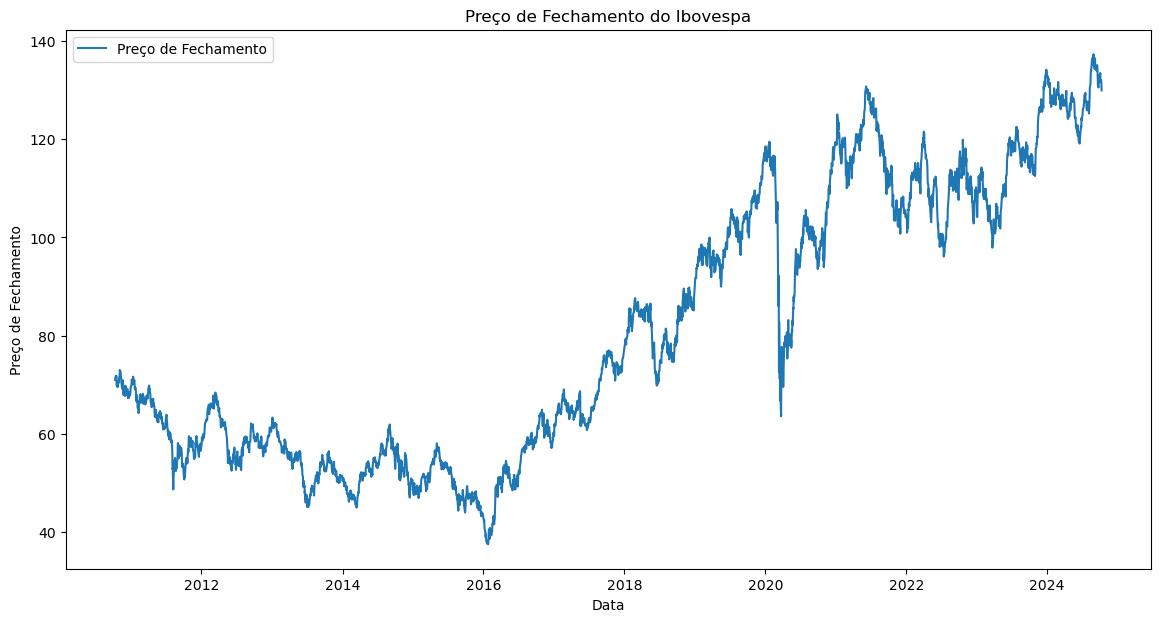

In [10]:
# Grafico de Linha de Preço de Fechamento do Ibovespa ao longo do tempo 

plt.figure(figsize=(14, 7))
plt.plot(data["date"], data["close"], label="Preço de Fechamento")
plt.title("Preço de Fechamento do Ibovespa")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
plt.legend()
plt.show()

* ##### Decompondo os resultados: O modelo multiplicativo é mais adequado quando a amplitude das flutuações sazonais aumenta ou diminui com o nível da série temporal. Isso significa que, à medida que os valores da série aumentam, as variações sazonais também aumentam. Melhor para dados não estacionários ou com tendência crescente/decrescente

In [11]:
results = seasonal_decompose(data["close"], model="multiplicative", period=365)

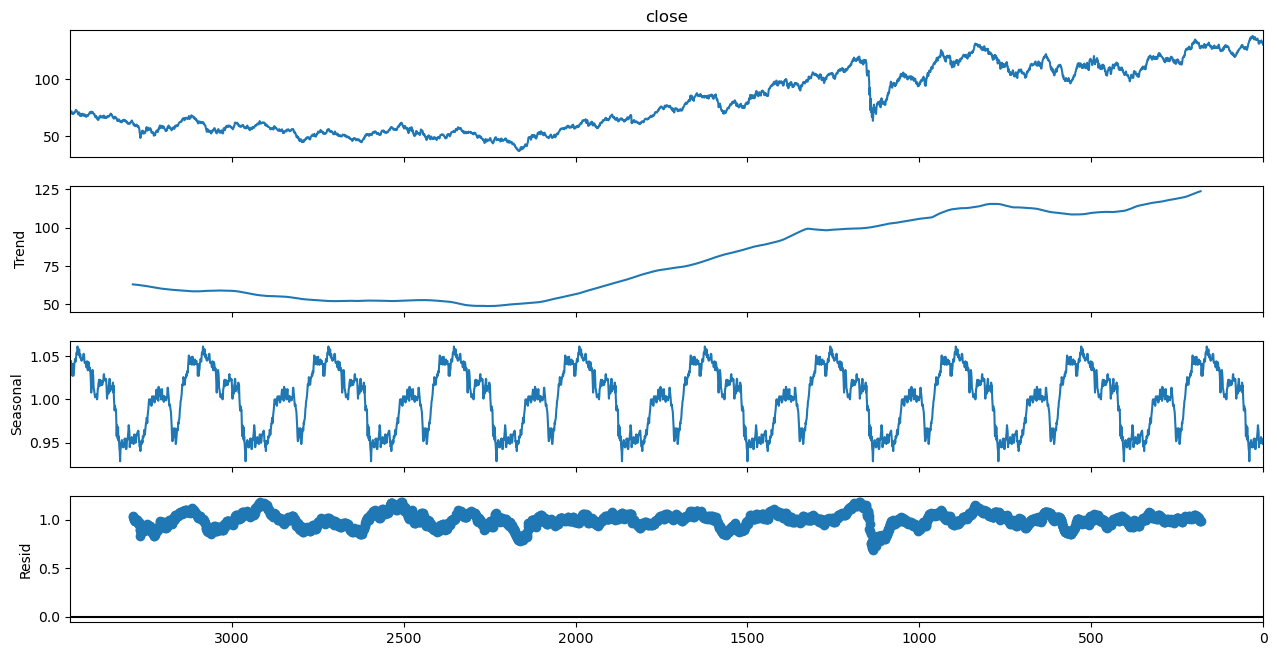

In [12]:
fig = results.plot()
fig.set_size_inches(14, 7)
plt.savefig('decomposicao.png')
plt.show()

##### 4. **Calculando os valores de Autocorrelação e Autocorrelação Parcial**

* ACF: A ACF mede a correlação entre uma observação e suas defasagens (valores passados). Isso ajuda a entender a extensão da dependência temporal na série. Se a ACF decai rapidamente, isso pode indicar que a série é de ordem de diferenciação baixa, enquanto um decaimento lento pode sugerir que a série possui dependência de longa duração.

* PACF:  A PACF mede a correlação entre uma observação e suas defasagens, eliminando o efeito das defasagens intermediárias. Isso é útil para identificar o número de termos autoregressivos (AR) no modelo. A PACF é particularmente importante para determinar até onde a autocorrelação persiste após considerar as defasagens anteriores.

In [13]:
# Definindo a função para cálculo e plotagem do ACF
def plot_acf(data, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))

    # Calculando os valores de  ACF e intervalo de confiança de 95%
    _plot_acf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(data, alpha=0.05, nlags=365)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The ACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The ACF coefficients do not intercept the threshold")

In [14]:
# Definindo a função para cálculo e plotagem do PACF
def plot_pacf(data, lags=30, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))

   # Calculando os valores de  ACF e intervalo de confiança de 95%
    _plot_pacf(data, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(data, alpha=0.05, nlags=365)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"The PACF coefficients intercept the threshold at lag {intercept_point[0][0]}"
        )
    else:
        print("The PACF coefficients do not intercept the threshold")

The ACF coefficients intercept the threshold at lag 327


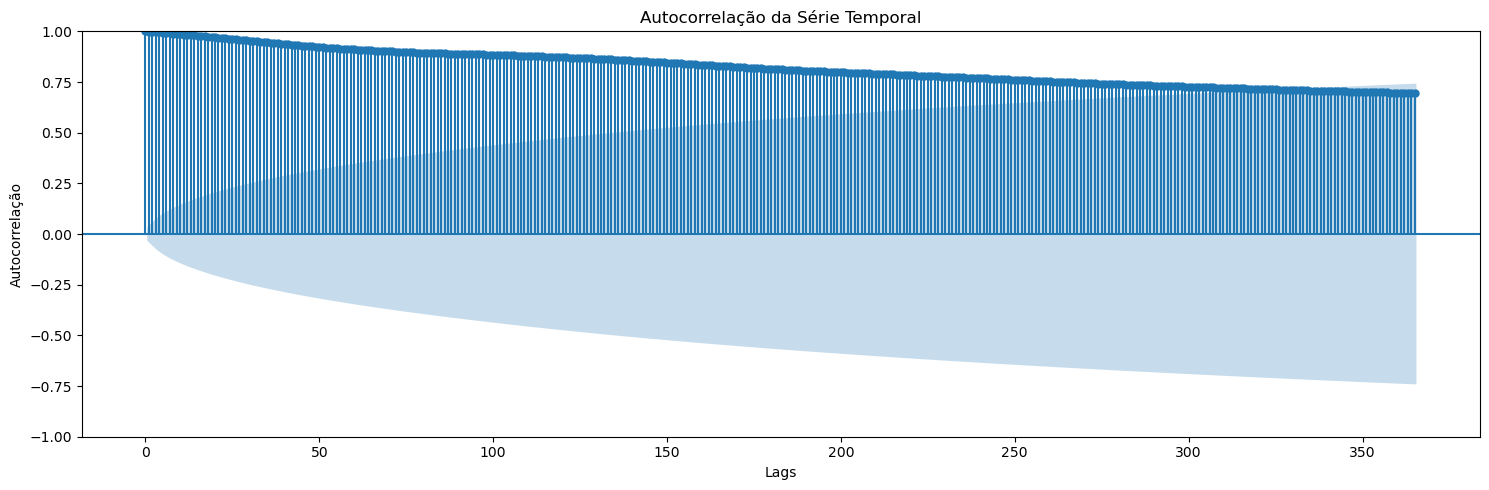

In [15]:
plot_acf(data["close"])
plt.savefig('acf.png')
plt.show()

The PACF coefficients intercept the threshold at lag 3


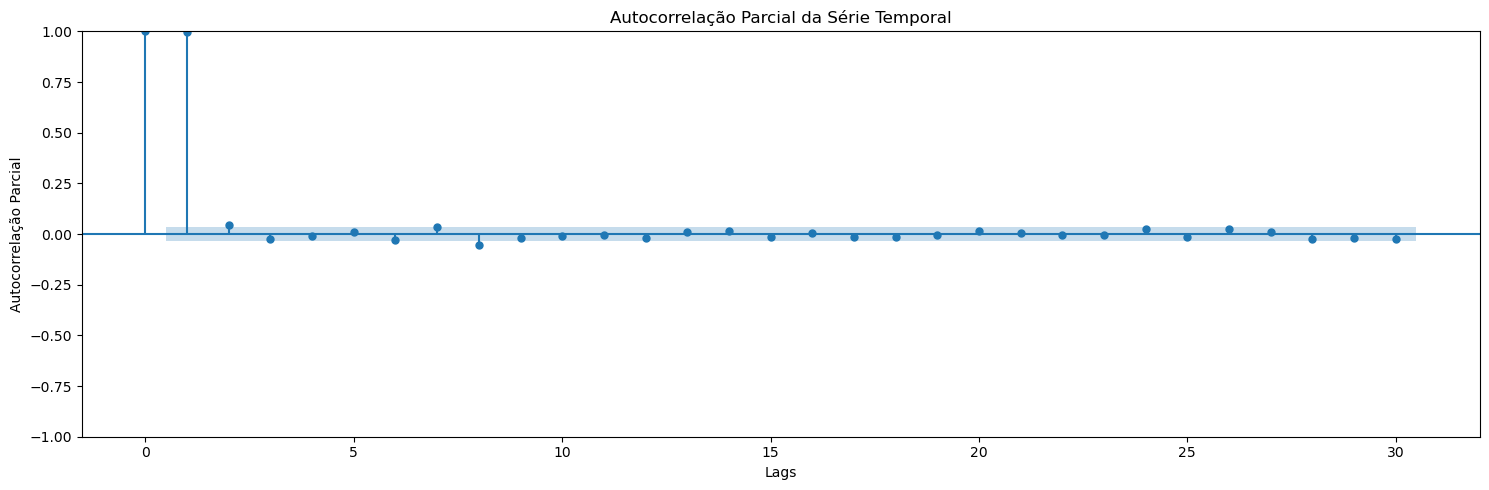

In [16]:
plot_pacf(data["close"])
plt.savefig('pacf.png')
plt.show()

##### 5. **Preparando os dados e calculando índices necessários para aplicações dos modelos escolhidos**

Para modelos de Series temporais como ARIMA, SARIMA e SARIMAX utilizar calculos com séries estácionárias bem como os parâmetros de p, q, d e seasonal order são fundamentais para que os modelos representem corretamente a estrutura dos dados . 

In [17]:
# Aplicando o teste de Augmented Dickey-Fuller para verificar a estacionariedade
adf_result = sm.tsa.adfuller(data["close"])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -0.7249890077130412
p-value: 0.8401702164476903
Critical Values: {'1%': -3.4322397354507372, '5%': -2.8623749771810916, '10%': -2.5672144733313327}
A série temporal não é estacionária


In [18]:
# diferenciando 1 vez e calculando o ADF novamente

adf_result = sm.tsa.adfuller(data["close"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -20.854932181251712
p-value: 0.0
Critical Values: {'1%': -3.4322397354507372, '5%': -2.8623749771810916, '10%': -2.5672144733313327}
A série temporal é estacionária


* ##### Observação: com aplicação de apenas uma diferenciação conseguimos converter a série temporal em estacionária 

* Calculando p, d e q


In [19]:
acf_x = sm.tsa.acf(data["close"], alpha=0.05, nlags=365)
acf, ci = acf_x[:2]
# identificação do q pelo ponto de interceptação ao 95% com o acf
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

pacf_x = sm.tsa.pacf(data["close"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]
# identificação do p pelo ponto de interceptação ao 95% com o pacf
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

d = 1  # apenas 1 diferenciação foi necessária para tornar a série estacionária

print(f"p: {p}, d: {d}, q: {q}")

p: 3, d: 1, q: 327


* Utilizando o autoarima para deterctar a seasonal order para aplicar ao modelo SARIMAX

In [20]:
model = pm.auto_arima(
    data["close"],
    seasonal=True,
    m=12,
    stepwise=True,
)

# Summary of the model's detected parameters
print(model.summary())

# Detectando a ordem sazonal 
seasonal_order = model.seasonal_order
print(f"Detected Seasonal Order: {seasonal_order}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3471
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5500.611
Date:                Mon, 14 Oct 2024   AIC                          11011.223
Time:                        11:55:29   BIC                          11041.982
Sample:                             0   HQIC                         11022.205
                               - 3471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5472      0.039    -39.918      0.000      -1.623      -1.471
ar.L2         -0.7257      0.039    -18.556      0.000      -0.802      -0.649
ma.L1          1.4785      0.042     35.073      0.0

##### 6. **Definindo funções para Cálculo,visualização e avaliação de métricas**

In [21]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")

##### 7. **Dividindo os dados de treino e teste**

In [22]:
# Dividindo em treino e teste

train_size = data.shape[0] - 7
train, test = data[:train_size], data[train_size:]

##### 8. **Treinando os modelos**

##### 8.1 Modelo XGBoost

In [23]:
# Preparação dos dados para XGBoost
def create_features(df):
    df["Date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    return df


train = create_features(train)
test = create_features(test)

FEATURES = ["year", "month", "day", "dayofweek", "open"]
TARGET = "close"

In [24]:
# Modelo XGBoost
X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]

reg = xgb.XGBRegressor(objective="reg:squarederror")
reg.fit(X_train, y_train)

# Avaliação XGBoost
preds = reg.predict(X_test)
metrics_xgb = calculate_metrics(y_test, preds)
print("XGBoost Metrics:")
print_metrics(metrics_xgb)

#calculando a acurácia do modelo
accuracy = 100 - metrics_xgb[2]
print(f"Acurácia: {accuracy:.2f} %")


XGBoost Metrics:
MAE: 1.2471050676618307
MSE: 2.7313956574239198
MAPE: 0.95 %
Acurácia: 99.05 %


##### 8.2 Modelo Prophet

In [25]:
# Modelo Prophet
train_prophet = train.rename(columns={"date": "ds", "close": "y"})
test_prophet = test.rename(columns={"date": "ds", "close": "y"})

model = Prophet(daily_seasonality=True)
model.add_regressor("open")
model.fit(train_prophet)

future = model.make_future_dataframe(periods=len(test))
future["open"] = pd.concat([train["open"], test["open"]], ignore_index=True)
forecast = model.predict(future)

preds = forecast[["ds", "yhat"]].tail(len(test))
preds = preds.set_index("ds")
y_test = test_prophet.set_index("ds")["y"]

metrics_pr = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_pr)

#calculando a acurácia do modelo
accuracy = 100 - metrics_pr[2]
print(f"Acurácia: {accuracy:.2f} %")


11:55:31 - cmdstanpy - INFO - Chain [1] start processing
11:55:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet Metrics:
MAE: 1.0441173829480752
MSE: 1.4243676067961109
MAPE: 0.79 %
Acurácia: 99.21 %


##### 8.3 Modelo SARIMAX

In [26]:
# Modelo SARIMAX
exog_train = train[["open"]]
exog_test = test[["open"]]

model = sm.tsa.statespace.SARIMAX(
    train["close"],
    exog=exog_train,
    order=(
        p,
        d,
        1,
    ),  
    seasonal_order=(0, 0, 0, 12),
   
)
results = model.fit()

preds = results.get_forecast(steps=len(test), exog=exog_test).predicted_mean
confidence_intervals = results.get_forecast(steps=len(test), exog=exog_test).conf_int()

metrics_sarimax = calculate_metrics(test["close"], preds)
print("SARIMAX Metrics:")
print_metrics(metrics_sarimax)

#calculando a acurácia do modelo
accuracy = 100 - metrics_sarimax[2]
print(f"Acurácia: {accuracy:.2f} %")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58763D+00    |proj g|=  2.88502D-03


 This problem is unconstrained.



At iterate    5    f=  1.58732D+00    |proj g|=  1.82967D-02

At iterate   10    f=  1.58656D+00    |proj g|=  1.90288D-03

At iterate   15    f=  1.58653D+00    |proj g|=  2.38471D-03

At iterate   20    f=  1.58619D+00    |proj g|=  1.34410D-02

At iterate   25    f=  1.58587D+00    |proj g|=  1.29383D-02

At iterate   30    f=  1.58536D+00    |proj g|=  6.94902D-03

At iterate   35    f=  1.58512D+00    |proj g|=  1.69251D-02

At iterate   40    f=  1.58500D+00    |proj g|=  6.27770D-03

At iterate   45    f=  1.58500D+00    |proj g|=  9.26359D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     54   

* ##### Observação: 
  Os parâmetros idealmente calculados para o modelos sarimax seriam um order=(3, 1, 327) e uma seasonal_order=(0, 0, 0, 12). Um q=327 pode levar a uma alta complexidade ou a um overfiting. O modelo então foi treinado com um q = 1 , outra vez com q = 10 e foi constatado que em termos  de acurácia foi detectada uma deterioração que apesar de matematicamente insignificante o aumento de complexidade e custo computacional foi altíssimo. 

##### 9. **Comparando os modelos**

In [27]:
df = pd.DataFrame(
    [metrics_xgb, metrics_pr, metrics_sarimax],
    columns=["MAE", "MSE", "MAPE"],
    index=["XGBoost", "Prophet", "SARIMAX"],
)
df.sort_values(by="MAPE", ascending=True)

,MAE,MSE,MAPE
SARIMAX,0.827026,1.015546,0.628205
Prophet,1.044117,1.424368,0.793037
XGBoost,1.247105,2.731396,0.946337


##### 10. **Modelos Testados**

Optamos por avaliar diferentes modelos para identificar aquele com melhor performance preditiva e que fosse operacionalmente viável. Abaixo está um resumo das técnicas testadas:

* Prophet: Bom para dados com sazonalidade clara, mas apresentou um erro significativo para dados com volatilidade diária alta.
* XGBoost: Modelo robusto para dados complexos, mas teve dificuldade em capturar as interações temporais com variáveis exógenas.
* SARIMAX: O modelo SARIMAX foi escolhido por sua capacidade de modelar a autocorrelação nos dados, lidar com diferenciação de tendência e incorporar variáveis exógenas relevantes, como o preço de abertura.

##### 10. **O modelo escolhido**
    Com um MAPE de 0,63 (63%) e uma acurácia de 99.21 %, o modelo SARIMAX apresentou uma boa precisão, adequada para as expectativas da equipe de investimentos. A melhoria adicional obtida ao ajustar o parâmetro q foi marginal, indicando que não seria vantajoso aumentar a complexidade do modelo além do necessário.

##### 11. **Previsão para os Próximos 7 Dias**
Realizamos previsões de curto prazo (7 dias) para apoiar a equipe de investimentos na tomada de decisão. Abaixo estão os resultados esperados para os próximos dias com base no modelo SARIMAX:

In [28]:
# Passo 1: Definir o horizonte de previsão (7 dias no exemplo)
h = 7

# Passo 2: Preparar as variáveis exógenas para a previsão
future_exog = test[['open']].iloc[:h]  # Usando 'open' como variável exógena

# Passo 3: Fazer as previsões com o SARIMAX
forecast = results.get_forecast(steps=h, exog=future_exog)

# Extrair a média e os intervalos de confiança (95%)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int(alpha=0.05)  # Intervalo de confiança de 95%

# Passo 4: Criar um DataFrame com as previsões
forecast_df = pd.DataFrame({
    'Data': test['date'].iloc[:h],  # Datas correspondentes às previsões
    'Intervalo inferior': confidence_intervals.iloc[:, 0].values,  # Limite inferior
    'Previsão': forecast_mean.values,  # Valores previstos
    'Intervalo superior': confidence_intervals.iloc[:, 1].values,  # Limite superior
})

# Exibir o DataFrame com as previsões sem o index
forecast_df.set_index('Data', inplace=True)
print(forecast_df)

            Intervalo inferior    Previsão  Intervalo superior
Data                                                          
2024-10-01          129.565571  131.880065          134.194559
2024-10-02          130.081190  132.395961          134.710732
2024-10-03          131.004679  133.335180          135.665680
2024-10-04          129.322417  131.665110          134.007804
2024-10-07          129.419224  131.773542          134.127860
2024-10-08          129.610976  131.976984          134.342991
2024-10-09          129.140087  131.517697          133.895308


##### 12. **Conclusão e Próximos Passos**
Com um MAPE de 63%, o modelo SARIMAX apresentou uma precisão adequada para atender às expectativas da equipe de investimentos. As previsões para os próximos 7 dias foram realizadas e indicam estabilidade nos preços, com pequenas variações dentro de um intervalo esperado.

* Próximos Passos:

1. Monitoramento: Continuar avaliando o modelo diariamente para garantir que ele se mantenha adequado às condições do mercado.
2. Ajustes Futuros: Se necessário, incorporar outras variáveis externas (como índices internacionais ou preços de commodities).
3. Integração: Automatizar a coleta dos dados e a execução do modelo para fornecer previsões contínuas à equipe de investimentos.

Com essa abordagem, esperamos oferecer suporte relevante e oportuno para a tomada de decisão, contribuindo para uma gestão de portfólio mais eficiente e informada.